# Sequential Neural Posterior Estimation (SNPE)

**Session 4, Part 3** - Hands-on exercise (~20 min)

In the previous notebook, we saw that **NPE struggled** with the Lotka-Volterra problem while **NLE performed well**. The issue: NPE must learn accurate posteriors across the entire prior space, but the true posterior is sharply concentrated.

**Solution: Sequential NPE (SNPE)** - Focus simulations where the posterior has mass!

## 1. Recap: The Problem with Amortized NPE

With standard (amortized) NPE:

```
Sample θ from PRIOR → Simulate x → Train
```

**Problem:** Most prior samples produce observations far from $x_o$!
- Wasted simulations in irrelevant regions
- Poor posterior approximation where it matters
- Need many simulations to cover the whole prior space

### The Sequential Idea

```
Round 1: Sample θ from PRIOR      → Simulate → Train → Get rough posterior
Round 2: Sample θ from POSTERIOR₁ → Simulate → Train → Get better posterior  
Round 3: Sample θ from POSTERIOR₂ → Simulate → Train → Get refined posterior
...
```

Each round **focuses simulations** on the region where the posterior has mass!

## 2. The SNPE API in `sbi`

The key pattern is a **loop** where each round:
1. Samples from the current `proposal` (prior in round 1, posterior in later rounds)
2. Simulates data for those parameters
3. Trains the density estimator
4. Builds a new posterior and sets it as the next proposal

### Key Functions

**Initialization:**
```python
from sbi.inference import SNPE, simulate_for_sbi

trainer = SNPE(prior)
proposal = prior  # Start with prior
```

**Data generation** (works with any proposal - prior or posterior):
```python
theta, x = simulate_for_sbi(simulator, proposal, num_simulations, num_workers=NUM_WORKERS)
```

**Training** (must tell SNPE where samples came from):
```python
trainer.append_simulations(theta, x, proposal=proposal)  # proposal argument is crucial!
trainer.train()
```

**Building posterior and updating proposal:**
```python
posterior = trainer.build_posterior()
proposal = posterior.set_default_x(x_o)  # Makes posterior usable as next proposal
```

**Key insight:** `posterior.set_default_x(x_o)` conditions the posterior on your observation, so when `simulate_for_sbi` samples from it, you get θ values that are likely given $x_o$!

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from functools import partial

from sbi.inference import SNPE, simulate_for_sbi

from simulators import (
    create_lotka_volterra_prior,
    generate_observed_data,
    lotka_volterra_simulator,
)
from utils import corner_plot

## 3. Setup

In [8]:
# Configuration
NUM_ROUNDS = 10
NUM_SIMS_PER_ROUND = 2000
NUM_WORKERS = 10  # Adjust based on your machine
USE_AUTOCORRELATION = True
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

print(f"Total simulations: {NUM_ROUNDS * NUM_SIMS_PER_ROUND}")

Total simulations: 20000


In [9]:
# Setup prior, simulator, and observation
prior = create_lotka_volterra_prior()
x_o, theta_true = generate_observed_data(use_autocorrelation=USE_AUTOCORRELATION)

simulator = partial(lotka_volterra_simulator, use_autocorrelation=USE_AUTOCORRELATION)

print(f"True parameters: {theta_true.numpy()}")
print(f"Observation shape: {x_o.shape}")

True parameters: [0.1  0.02 0.01 0.1 ]
Observation shape: torch.Size([1, 20])


## 4. Exercise: Implement Multi-Round SNPE

**Your task:** Complete the SNPE training loop below.

For each round, you need to:
1. Generate training data using `simulate_for_sbi` with the current `proposal`
2. Append simulations to the trainer (don't forget the `proposal` argument!)
3. Train the density estimator
4. Build the posterior and store it
5. **Crucially:** Update the `proposal` for the next round using `set_default_x(x_o)`

**Hint:** Look at the API section above for the key function calls.

In [10]:
# Initialize
trainer = SNPE(prior)
proposal = prior  # Start sampling from the prior
posteriors = []   # Store posteriors from each round

for round_idx in range(NUM_ROUNDS):
    print(f"\n=== Round {round_idx + 1} ===")
    
    # TODO Step 1: Generate training data by sampling from the proposal
    # Use the built-in function simulate_for_sbi
    print(f"Simulating {NUM_SIMS_PER_ROUND} samples...")
    theta, x = simulate_for_sbi(simulator, proposal, NUM_SIMS_PER_ROUND, num_workers = NUM_WORKERS)

    # TODO Step 2: Append simulations to trainer
    # Important: pass proposal=proposal so SNPE knows where samples came from
    trainer.append_simulations(theta, x, proposal = proposal)
    
    # TODO Step 3: Train
    print("Training...")
    trainer.train()
    
    # TODO Step 4: Build posterior and store it
    posterior =  trainer.build_posterior()
    posteriors.append(posterior)
    
    # TODO Step 5: Update proposal for next round
    # Use posterior.set_default_x(x_o) to condition on our observation
    proposal = posterior.set_default_x(x_o)

print("\n=== Done ===")


=== Round 1 ===
Simulating 2000 samples...


  0%|          | 0/2000 [00:00<?, ?it/s]

Training...
 Neural network successfully converged after 389 epochs.
=== Round 2 ===
Simulating 2000 samples...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Training...
Using SNPE-C with atomic loss
 Neural network successfully converged after 89 epochs.
=== Round 3 ===
Simulating 2000 samples...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Training...
Using SNPE-C with atomic loss
 Neural network successfully converged after 63 epochs.
=== Round 4 ===
Simulating 2000 samples...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Training...
Using SNPE-C with atomic loss
 Neural network successfully converged after 30 epochs.
=== Round 5 ===
Simulating 2000 samples...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Training...
Using SNPE-C with atomic loss
 Neural network successfully converged after 52 epochs.
=== Round 6 ===
Simulating 2000 samples...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Training...
Using SNPE-C with atomic loss
 Neural network successfully converged after 44 epochs.
=== Round 7 ===
Simulating 2000 samples...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Training...
Using SNPE-C with atomic loss
 Neural network successfully converged after 55 epochs.
=== Round 8 ===
Simulating 2000 samples...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Training...
Using SNPE-C with atomic loss
 Neural network successfully converged after 32 epochs.
=== Round 9 ===
Simulating 2000 samples...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Training...
Using SNPE-C with atomic loss
 Neural network successfully converged after 84 epochs.
=== Round 10 ===
Simulating 2000 samples...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Training...
Using SNPE-C with atomic loss
 Neural network successfully converged after 102 epochs.
=== Done ===


In [ ]:
# %load solutions/solutions_nb_4b_1.py

## 5. Sample from Final Posterior

In [11]:
# Get samples from each round for comparison
num_posterior_samples = 1000
samples_across_rounds = [posteriors[_].sample((num_posterior_samples,), x=x_o, show_progress_bars=False) for _ in range(len(posteriors))]
snpe_samples = posteriors[-1].sample((num_posterior_samples,), x=x_o, show_progress_bars=False)

## 6. Visualize: Posterior Evolution Across Rounds

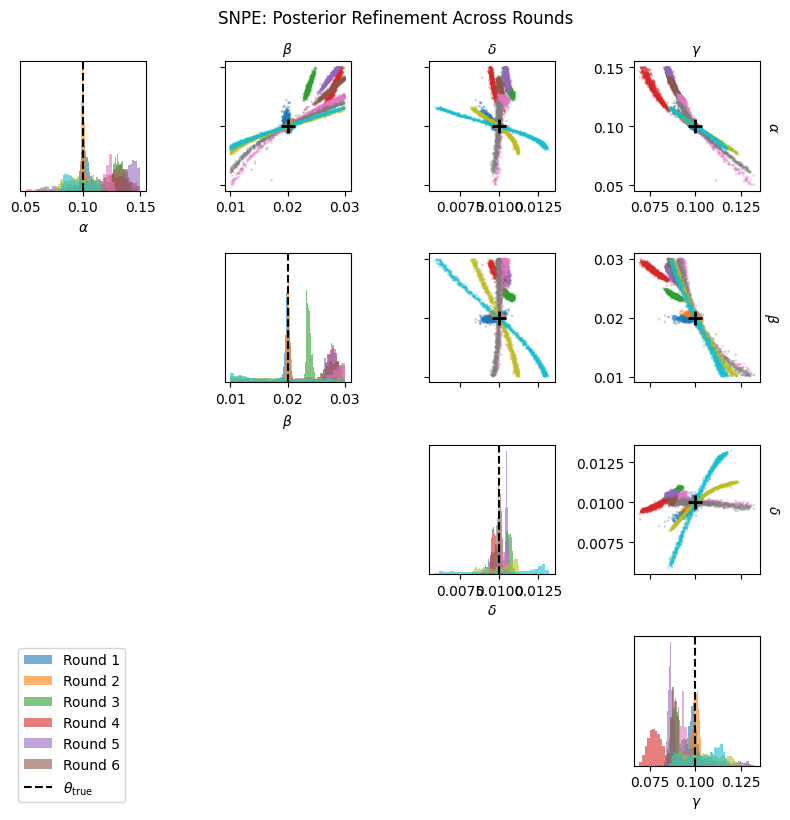

In [ ]:
# Visualize posterior evolution across rounds
param_names = [r"$\alpha$", r"$\beta$", r"$\delta$", r"$\gamma$"]
prior_limits = [[prior.base_dist.low[i].item(), prior.base_dist.high[i].item()] for i in range(4)]

fig, axes = corner_plot(
    samples_across_rounds,
    labels=[f"Round {i+1}" for i in range(NUM_ROUNDS)],
    param_names=param_names,
    theta_true=theta_true,
    # limits=prior_limits,
)
plt.suptitle("SNPE: Posterior Refinement Across Rounds", y=1.02, fontsize=12)
plt.show()

## 7. Compare: SNPE vs NPE vs NLE

In [15]:
# Load NPE and NLE samples from previous notebook
import os

if os.path.exists('npe_nle_samples.pt'):
    saved_data = torch.load('npe_nle_samples.pt', weights_only=True)
    npe_samples = saved_data['npe_samples']
    nle_samples = saved_data['nle_samples']
    print("Loaded NPE and NLE samples from nb_04")
else:
    print("Warning: 'npe_nle_samples.pt' not found. Run nb_04 first!")
    print("Using placeholder values for comparison.")
    npe_samples = None
    nle_samples = None

Loaded NPE and NLE samples from nb_04


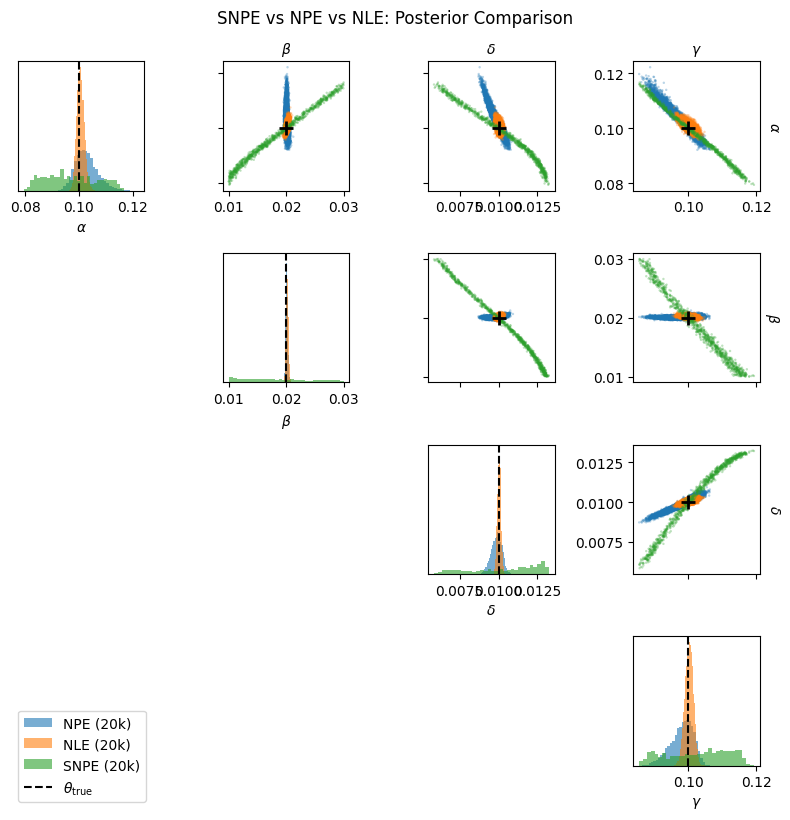

In [16]:
# Visual comparison: SNPE vs NPE vs NLE posteriors
if npe_samples is not None and nle_samples is not None:
    fig, axes = corner_plot(
        [npe_samples, nle_samples, snpe_samples],
        labels=["NPE (20k)", "NLE (20k)", "SNPE (20k)"],
        param_names=param_names,
        theta_true=theta_true,
        # limits=prior_limits,
    )
    plt.suptitle("SNPE vs NPE vs NLE: Posterior Comparison", y=1.02, fontsize=12)
    plt.show()

## 8. Posterior Predictive Check

Let's validate SNPE by checking if simulations from posterior samples match the observed data.

In [17]:
from simulators import simulate

# Generate predictive time series from SNPE posterior
n_predictive = 50
time = np.arange(0, 200, 0.1)

# Observed time series
ts_observed = simulate(theta_true.numpy())

# SNPE predictive time series
snpe_predictive_theta = snpe_samples[:n_predictive]
ts_snpe = [simulate(snpe_predictive_theta[i].numpy()) for i in range(n_predictive)]

# NPE and NLE predictive (if available)
if npe_samples is not None:
    npe_predictive_theta = npe_samples[:n_predictive]
    ts_npe = [simulate(npe_predictive_theta[i].numpy()) for i in range(n_predictive)]
if nle_samples is not None:
    nle_predictive_theta = nle_samples[:n_predictive]
    ts_nle = [simulate(nle_predictive_theta[i].numpy()) for i in range(n_predictive)]

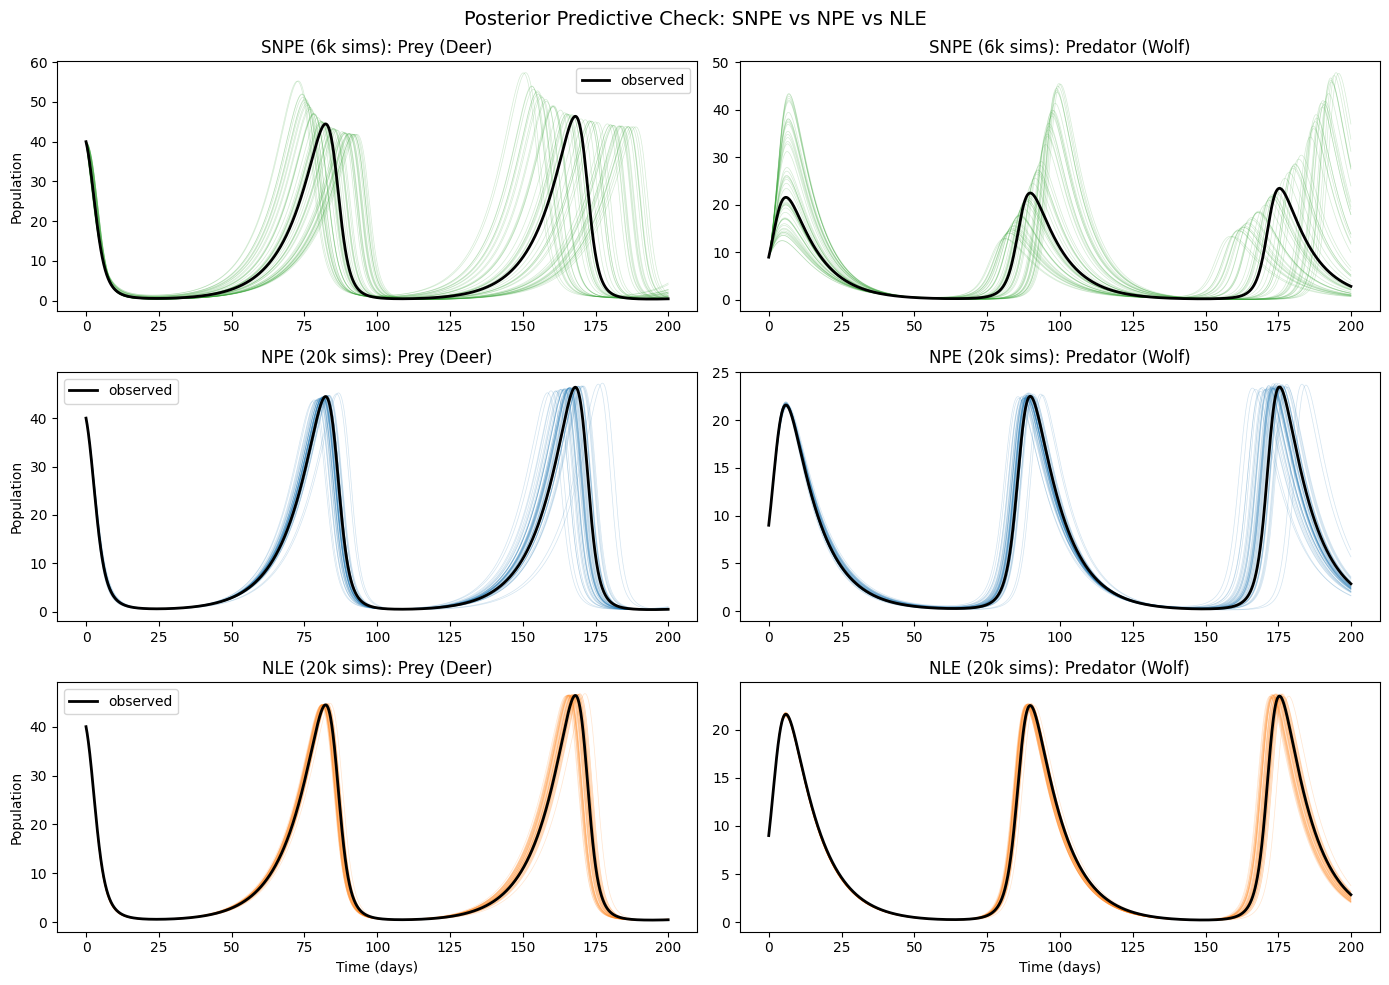

In [18]:
# Compare predictive time series: SNPE vs NPE vs NLE
fig, axes = plt.subplots(3, 2, figsize=(14, 10))

# SNPE predictive
ax = axes[0, 0]
for ts in ts_snpe:
    ax.plot(time, ts[:, 0], color="C2", alpha=0.2, linewidth=0.5)
ax.plot(time, ts_observed[:, 0], color="k", linewidth=2, label="observed")
ax.set_ylabel("Population")
ax.set_title("SNPE (6k sims): Prey (Deer)")
ax.legend()

ax = axes[0, 1]
for ts in ts_snpe:
    ax.plot(time, ts[:, 1], color="C2", alpha=0.2, linewidth=0.5)
ax.plot(time, ts_observed[:, 1], color="k", linewidth=2)
ax.set_title("SNPE (6k sims): Predator (Wolf)")

# NPE predictive
if npe_samples is not None:
    ax = axes[1, 0]
    for ts in ts_npe:
        ax.plot(time, ts[:, 0], color="C0", alpha=0.2, linewidth=0.5)
    ax.plot(time, ts_observed[:, 0], color="k", linewidth=2, label="observed")
    ax.set_ylabel("Population")
    ax.set_title("NPE (20k sims): Prey (Deer)")
    ax.legend()

    ax = axes[1, 1]
    for ts in ts_npe:
        ax.plot(time, ts[:, 1], color="C0", alpha=0.2, linewidth=0.5)
    ax.plot(time, ts_observed[:, 1], color="k", linewidth=2)
    ax.set_title("NPE (20k sims): Predator (Wolf)")

# NLE predictive
if nle_samples is not None:
    ax = axes[2, 0]
    for ts in ts_nle:
        ax.plot(time, ts[:, 0], color="C1", alpha=0.2, linewidth=0.5)
    ax.plot(time, ts_observed[:, 0], color="k", linewidth=2, label="observed")
    ax.set_xlabel("Time (days)")
    ax.set_ylabel("Population")
    ax.set_title("NLE (20k sims): Prey (Deer)")
    ax.legend()

    ax = axes[2, 1]
    for ts in ts_nle:
        ax.plot(time, ts[:, 1], color="C1", alpha=0.2, linewidth=0.5)
    ax.plot(time, ts_observed[:, 1], color="k", linewidth=2)
    ax.set_xlabel("Time (days)")
    ax.set_title("NLE (20k sims): Predator (Wolf)")

plt.suptitle("Posterior Predictive Check: SNPE vs NPE vs NLE", fontsize=14)
plt.tight_layout()
plt.show()

## 9. Discussion

### What We Learned

| Method | Simulations | Posterior Quality | Amortized? |
|--------|-------------|-------------------|------------|
| NPE | 20,000 | Wider (struggled) | Yes |
| NLE | 20,000 | Tight, accurate | Partial |
| **SNPE** | **20,000** | Tight, accurate | No |

### SNPE Trade-offs

**Advantages:**
- Much more simulation-efficient for a specific observation
- Can achieve tight posteriors even when amortized NPE struggles
- Iteratively improves the posterior estimate

**Disadvantages:**
- **Not amortized**: Must re-run for each new observation
- Requires multiple training rounds (more wall-clock time)
- Need to choose number of rounds and simulations per round

### When to Use SNPE?

1. **Expensive simulations**: Each simulation counts, can't afford 100k+ samples
2. **Sharp posteriors**: Amortized NPE would need too many simulations
3. **Single observation**: You have one $x_o$ and need the best possible posterior
4. **Prior is broad**: Large prior-to-posterior contraction

## 10. Summary

### The Sequential SBI Family

| Method | What it learns | Sequential variant |
|--------|---------------|-------------------|
| NPE | $p(\theta|x)$ | **SNPE** |
| NLE | $p(x|\theta)$ | SNLE |
| NRE | $p(x|\theta)/p(x)$ | SNRE |

All sequential methods follow the same principle: **focus simulations where they matter**.

### Key Takeaways

1. **Sequential methods are simulation-efficient** - Important when simulations are expensive
2. **Trade-off: efficiency vs amortization** - SNPE gives better posteriors but only for one $x_o$
3. **SNPE can rescue NPE** - When amortized NPE struggles with sharp posteriors
4. **Choose based on your use case**:
   - Many observations, cheap simulations → NPE
   - One observation, expensive simulations → SNPE
   - Sharp posteriors, need MCMC flexibility → NLE/SNLE

---

**Congratulations!** You've now seen the main SBI methods:
- ABC (Session 2)
- NPE with neural density estimators (Sessions 2-3)
- NLE with MCMC (Session 4)
- SNPE for simulation efficiency (Session 4)

You're (almost) ready for the **hackathon**! Apply these methods to your own problems.